In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import qmc

In [3]:
def diff_eqs(input, t, parameters):
  beta_11 = parameters[0] 
  beta_12 = parameters[1] #Group 1 is infected by group 2
  beta_21 = parameters[2] #Group 2 is infected by group 1
  beta_22 = parameters[3]

  gamma = parameters[4]
  chi = parameters[5]

  epsilon_11 = parameters[6] 
  epsilon_12 = parameters[7] #Group 1 is infected by group 2
  epsilon_21 = parameters[8] #Group 2 is infected by group 1
  epsilon_22 = parameters[9]

  theta = parameters[10]
  mu = parameters[11]
  tau = parameters[12] #Testing rate
  rho = parameters[13] #Result return rate
  fnr = parameters[14] #False negative rate
  fpr = parameters[15] #False positive rate

  Y = np.zeros((24)) #SIRVQD
  V = input
  N = V[0]+V[1]+V[2]+V[3]+V[4]+V[5]+V[6]+V[7]+V[8]+V[9]+V[10] + V[12]+V[13]+V[14]+V[15]+V[16]+V[17]+V[18]+V[19]+V[20]+V[21]+V[22] #Not including dead individuals
  S_effective_1 = V[0]+V[1]+V[2]
  V_effective_1 = V[6]+V[7]+V[8]
  I_active_1 = V[3]+V[4]+V[5]
  S_effective_2 = V[0]+V[1]+V[2]
  V_effective_2 = V[6]+V[7]+V[8]
  I_active_2 = V[3]+V[4]+V[5]
  #Group 1
  Y[0] = -beta_11*I_active_1*V[0]/N-beta_12*I_active_2*V[0]/N-chi-tau*V[0]
  Y[1] = -beta_11*I_active_1*V[1]/N-beta_12*I_active_2*V[1]/N-chi-rho*V[1]+tau*V[0]
  Y[2] = -beta_11*I_active_1*V[2]/N-beta_12*I_active_2*V[2]/N-chi+rho*(1-fpr)*V[1]
  Y[3] = beta_11*S_effective_1*I_active_1/N+beta_12*I_active_2*S_effective_1/N+epsilon_11*V_effective_1*I_active_1/N+epsilon_12*V_effective_1*I_active_2/N-gamma*V[3]-mu*V[3]-tau*V[3]
  Y[4] = -rho*V[4]+tau*V[3]
  Y[5] = rho*fnr*V[4]-gamma*V[5]-mu*V[5]
  Y[6] = -epsilon_11*I_active_1*V[6]/N-epsilon_12*I_active_2*V[6]/N+chi-tau*V[6]
  Y[7] = -epsilon_11*I_active_1*V[7]/N-epsilon_12*I_active_2*V[7]/N+chi-rho*V[7]+tau*V[6]
  Y[8] = -epsilon_11*I_active_1*V[8]/N-epsilon_12*I_active_2*V[8]/N+chi+rho*(1-fpr)*V[7]
  Y[9] = rho*fpr*V[1]+rho*(1-fnr)*V[4]+rho*fpr*V[7]-gamma*V[9]-mu*V[9]
  Y[10] = gamma*(V[3]+V[5])+gamma*V[9]
  Y[11] = mu*(V[3]+V[5])+mu*V[9]
  #Group 2
  Y[12] = -beta_22*I_active_2*V[12]/N-beta_21*I_active_1*V[12]/N-chi-tau*V[12]
  Y[13] = -beta_22*I_active_2*V[13]/N-beta_21*I_active_1*V[13]/N-chi-rho*V[13]+tau*V[12]
  Y[14] = -beta_22*I_active_2*V[14]/N-beta_21*I_active_1*V[14]/N-chi+rho*(1-fpr)*V[13]
  Y[15] = beta_22*S_effective_2*I_active_2/N+beta_21*I_active_1*S_effective_2/N+epsilon_22*V_effective_2*I_active_2/N+epsilon_21*V_effective_2*I_active_1/N-gamma*V[15]-mu*V[15]-tau*V[15]
  Y[16] = -rho*V[16]+tau*V[15]
  Y[17] = rho*fnr*V[16]-gamma*V[17]-mu*V[17]
  Y[18] = -epsilon_22*I_active_2*V[18]/N-epsilon_21*I_active_1*V[18]/N+chi-tau*V[18]
  Y[19] = -epsilon_22*I_active_2*V[19]/N-epsilon_21*I_active_1*V[19]/N+chi-rho*V[19]+tau*V[18]
  Y[20] = -epsilon_22*I_active_2*V[20]/N-epsilon_21*I_active_1*V[20]/N+chi+rho*(1-fpr)*V[19]
  Y[21] = rho*fpr*V[13]+rho*(1-fnr)*V[16]+rho*fpr*V[19]-gamma*V[21]-mu*V[21]
  Y[22] = gamma*(V[15]+V[17])+gamma*V[21]
  Y[23] = mu*(V[15]+V[17])+mu*V[21]
  return Y

First, assume that teh mean of beta_11 and beta_22 is roughly beta and beta_12, beta_21 are both less than beta_11 and beta_22. ie. transmission within subgroups is close to the population wide transmission. Transmission across groups is lower. Assume that for one group (e.g. higher income), they have lower starting infections and higher starting vaccinations.

In [15]:
starting_infections_1 = 0.001 #0.01% of group 1 starts off infected
starting_vaccinations_1 = 0.0

starting_infections_2 = 0.0001 #0.001% of group 2 starts off infected
starting_vaccinations_2 = 0.001 #0.1% of group 2 starts off vaccinated

INPUT_0 = np.array([1-starting_infections_1-starting_vaccinations_1, 0, 0, starting_infections_1, 0, 0, starting_vaccinations_1, 0, 0, 0, 0, 0, 
                    1-starting_infections_2-starting_vaccinations_2, 0, 0, starting_infections_2, 0, 0, starting_vaccinations_2, 0, 0, 0, 0, 0])*10**6 # Initial values of SIRVQD scaled to a population of one million
R0 = 16
CFR = 0.0653 # Case fatality rate
gamma = 0.0714*(1-CFR)
mu = 0.0714*CFR
beta = R0*(gamma+mu)

ND_end = 100 # Number of days to simulate
t_start = 0.0; t_end = ND_end; t_inc = 0.05
t_range_init = np.arange(t_start, t_end+t_inc, t_inc) # Time points to solve the system at

In [16]:
param_bounds = {
    'chi': (0, 0.01*10**6),
    'beta_11': (0.5 * beta, 1.5 * beta), #The mean of beta_11 and beta_22 is roughly beta
    'beta_22': (0.5 * beta, 1.5 * beta),
    'epsilon_11': (0, beta), 
    'epsilon_22': (0, beta),
    'theta': (0, 1),
    'tau': (0.01, 1),
    'rho': (0, 1),
    'fnr': (0, 0.3), 
    'fpr': (0, 0.3)
}

param_names = list(param_bounds.keys())

In [17]:
#Generate 1000 samples in [0, 1] for each parameter
n_samples = 1000
sampler = qmc.LatinHypercube(d=len(param_bounds))
lhs_samples = sampler.random(n=n_samples)

#Scale the samples to actual range
param_ranges = np.array([param_bounds[name] for name in param_names])
scaled_samples = qmc.scale(lhs_samples, param_ranges[:, 0], param_ranges[:, 1])

In [ ]:
def simulate_model(params): 
    chi, beta_11, beta_22, epsilon_11, epsilon_22, theta, tau, rho, fnr, fpr = params
    beta_12 = np.random.exponential(scale=beta/2) #Has a mean less than beta
    beta_21 = beta_12
    epsilon_12 = np.random.exponential(scale=((epsilon_11+epsilon_22)/2)/2) #Has a mean less than the mean of epsilon_11 and epsilon_22
    epsilon_21 = epsilon_12
    all_params = np.array([beta_11, beta_12, beta_21, beta_22, gamma, chi, epsilon_11, epsilon_12, epsilon_21, epsilon_22, theta, mu, tau, rho, fnr, fpr])

    RES_init = spi.odeint(diff_eqs,INPUT_0,t_range_init,args=(all_params,))

    I_model_1 = RES_init[:, 3] + RES_init[:, 4] + RES_init[:, 5]  #Compare the infected to the target data of group 1
    I_model_2 = RES_init[:, 15] + RES_init[:, 16] + RES_init[:, 17] #Compare the infected to the target data of group 2
    V_model_1 = RES_init[:, 6] + RES_init[:, 7] + RES_init[:, 8] #Compare the vaccinated to the target data of group 1
    V_model_2 = RES_init[:, 18] + RES_init[:, 19] + RES_init[:, 20] #Compare the vaccinated to the target data of group 2
    D_model_1 = RES_init[:, 11]
    D_model_2 = RES_init[:, 23]
    return I_model_1, I_model_2, V_model_1, V_model_2, D_model_1, D_model_2

In [22]:
def MSE_func(params, I_data_1, I_data_2, V_data_1, V_data_2, D_data_1, D_data_2): 
    I_model_1, I_model_2, V_model_1, V_model_2, D_model_1, D_model_2 = simulate_model(params)
    I_model_1 = I_model_1[:len(I_data_1)]
    I_model_2 = I_model_2[:len(I_data_2)]
    V_model_1 = V_model_1[:len(V_data_1)]
    V_model_2 = V_model_2[:len(V_data_2)]
    D_model_1 = D_model_1[:len(D_data_1)]
    D_model_2 = D_model_2[:len(D_data_2)]
    return np.mean((I_model_1 - I_data_1) ** 2) + np.mean((V_model_1 - V_data_1) ** 2) + np.mean((D_model_1 - D_data_1) ** 2) + np.mean((I_model_2 - I_data_2) ** 2) + np.mean((V_model_2 - V_data_2) ** 2) + np.mean((D_model_2 - D_data_2) ** 2)

In [23]:
#Loop over all samples and track the best 
I_data_1 = np.linspace(0.001 * 10**6, 10000, 100) + np.random.normal(0, 10, 100) #Change later on to be real data
I_data_2 = np.linspace(0.0001 * 10**6, 1000, 100) + np.random.normal(0, 10, 100)
V_data_1 = np.linspace(0, 0.001 * 10**6, 100) + np.random.normal(0, 100, 100)
V_data_1 = np.clip(V_data_1, 0, None) 
V_data_2 = np.linspace(0.001 * 10**6, 0.01 * 10**6, 100) + np.random.normal(0, 100, 100)
V_data_2 = np.clip(V_data_2, 0, None)
D_data_1 = np.linspace(1, 200, 100) + np.random.normal(0, 5, 100)
D_data_1 = np.clip(D_data_1, 0, None)
D_data_2 = np.linspace(1, 100, 100) + np.random.normal(0, 5, 100)
D_data_2 = np.clip(D_data_2, 0, None)

best_params = None
lowest_error = np.inf
for sample in scaled_samples: 
    error = MSE_func(sample, I_data_1, I_data_2, V_data_1, V_data_2, D_data_1, D_data_2)
    if error < lowest_error: 
        lowest_error = error
        best_params = sample 
print("Best parameter set:", dict(zip(param_names, best_params)))

/var/folders/h1/w_jtl0654ns96y8ngd075fj40000gn/T/ipykernel_51595/848624329.py:9: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  RES_init = spi.odeint(diff_eqs,INPUT_0,t_range_init,args=(all_params,))


Best parameter set: {'chi': 295.7433196932128, 'beta_11': 1.2902990480245575, 'beta_22': 0.8631395244824818, 'epsilon_11': 0.7536621737797753, 'epsilon_22': 0.35286115342892943, 'theta': 0.610937859980258, 'tau': 0.4792388368433341, 'rho': 0.4299370890824445, 'fnr': 0.024979564876868265, 'fpr': 0.19493670524671805}


In [25]:
#Simulate model using the best parameter choices 
chi, beta_11, beta_22, epsilon_11, epsilon_22, theta, tau, rho, fnr, fpr = best_params
beta_12 = np.random.exponential(scale=beta/2) #Should be adjusted
beta_21 = beta_12
epsilon_12 = np.random.exponential(scale=((epsilon_11+epsilon_22)/2)/2)
epsilon_21 = epsilon_12
all_params = np.array([beta_11, beta_12, beta_21, beta_22, gamma, chi, epsilon_11, epsilon_12, epsilon_21, epsilon_22, theta, mu, tau, rho, fnr, fpr])
RES_init = spi.odeint(diff_eqs,INPUT_0,t_range_init,args=(all_params,))

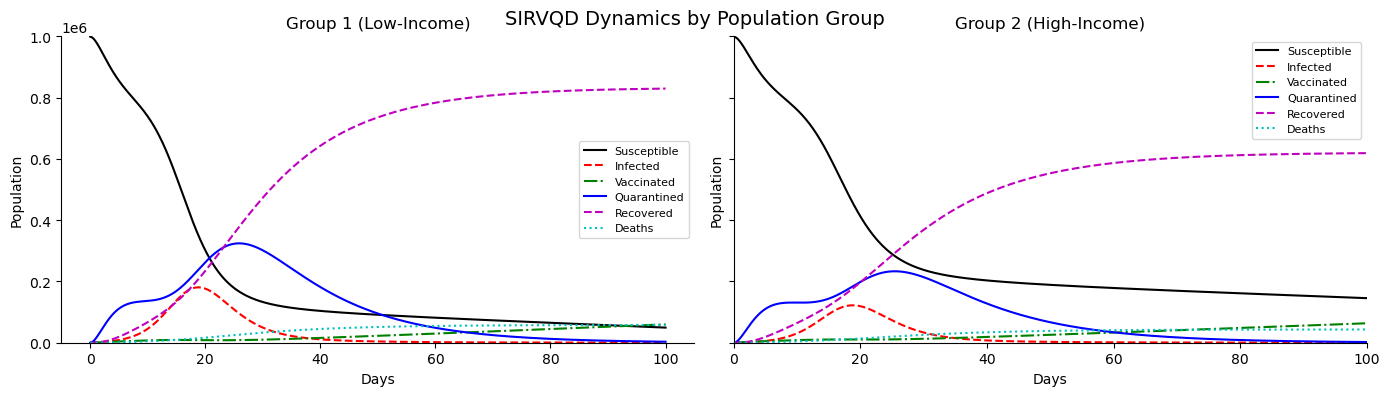

In [27]:
fig, ax= plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

t_vals = np.arange(0, ND_end + t_inc, t_inc)

#Group 1 
S1_total = RES_init[:, 0] + RES_init[:, 1] + RES_init[:, 2]  # S_nt + S_wt + S_tn
I1_total = RES_init[:, 3] + RES_init[:, 4] + RES_init[:, 5]  # I_nt + I_wt + I_tn
V1_total = RES_init[:, 6] + RES_init[:, 7] + RES_init[:, 8]  # V_nt + V_wt + V_tn
Q1 = RES_init[:, 9]
R1 = RES_init[:, 10]
D1 = RES_init[:, 11]

ax[0].plot(t_vals, S1_total, '-k', label='Susceptible') # S
ax[0].plot(t_vals, I1_total, '--r', label='Infected') # I
ax[0].plot(t_vals, V1_total, '-.g', label='Vaccinated') # V
ax[0].plot(t_vals, Q1, '-b', label='Quarantined') # Q
ax[0].plot(t_vals, R1, '--m', label='Recovered') # R
ax[0].plot(t_vals, D1, ':c', label='Deaths') # D

ax[0].set_title("Group 1 (Low-Income)")
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Population")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].legend(fontsize=8)

#Group 2
S2_total = RES_init[:, 12] + RES_init[:, 13] + RES_init[:, 14]
I2_total = RES_init[:, 15] + RES_init[:, 16] + RES_init[:, 17]
V2_total = RES_init[:, 18] + RES_init[:, 19] + RES_init[:, 20]
Q2 = RES_init[:, 21]
R2 = RES_init[:, 22]
D2 = RES_init[:, 23]

ax[1].plot(t_vals, S2_total, '-k', label='Susceptible')
ax[1].plot(t_vals, I2_total, '--r', label='Infected')
ax[1].plot(t_vals, V2_total, '-.g', label='Vaccinated')
ax[1].plot(t_vals, Q2, '-b', label='Quarantined')
ax[1].plot(t_vals, R2, '--m', label='Recovered')
ax[1].plot(t_vals, D2, ':c', label='Deaths')

ax[1].set_title("Group 2 (High-Income)")
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Population")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].legend(fontsize=8)

plt.xlim([0,ND_end])
plt.ylim([0,sum(INPUT_0)/2])
plt.tight_layout()
plt.suptitle("SIRVQD Dynamics by Population Group", fontsize=14)
plt.show()

**Next Steps:**
- Investiagte why quarantining is multimodal
- Generalize for N layers 
- Vacinnation rate potentially flawed? 
- Use real data for the loss function